In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Multi Label Deep Learning Model

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
df.iloc[:, 0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [4]:
df.iloc[0, :]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [7]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [9]:
x, y = dsets.train[0]
x,y

(fname       001385.jpg
 labels         bus car
 is_valid         False
 Name: 685, dtype: object,
 fname       001385.jpg
 labels         bus car
 is_valid         False
 Name: 685, dtype: object)

In [10]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('001669.jpg', 'cat')

In [12]:
# use verbose approach then lambda function for training
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002120.jpg', 'bird person')

In [13]:
# independent variable need to convert into complete path, so that we can open it as image
# dependent variable need to split on space charactor
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/006096.jpg'), ['bus'])

In [14]:
# to open image, convert to tensors and use sets of transforms, ex: ImageBlock
# But CategoryBlock won't work in case if multi-label, so use MultiCategoryBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=357x500,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 0.]))

In [15]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#2) ['bottle','person']

In [16]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x,
                  get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [17]:
# creating dataloaders from DataBlock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  splitter=splitter,
                  get_x=get_x,
                  get_y=get_y,
                  item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

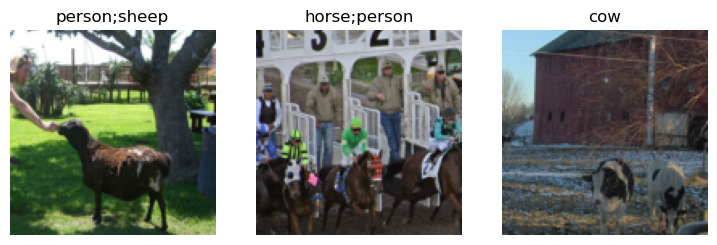

In [18]:
dls.show_batch(nrows=1, ncols=3)

In [19]:
learn = vision_learner(dls, resnet18)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [21]:
activs[0]

TensorBase([ 2.3099, -2.4355,  2.3554,  1.8852,  1.5836, -2.0871,  4.0859,
            -4.0973, -0.2637, -4.3150, -1.0726, -2.0705, -1.4039, -2.2245,
            -2.7040, -0.2736, -0.1254, -1.8277, -5.3823, -7.9444],
           grad_fn=<AliasBackward0>)

In [22]:
# Calculating loss with binary cross-entropy loss function
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [23]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0607, grad_fn=<AliasBackward0>)

In [24]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'targ' are the same size"
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [25]:
# Training model with different threshold values
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.946472,0.698003,0.235259,00:45
1,0.826982,0.569508,0.287390,00:34
2,0.608006,0.202262,0.823147,00:34
3,0.364868,0.127831,0.938626,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133430,0.116715,0.949522,00:36
1,0.118372,0.108049,0.949084,00:35
2,0.096308,0.103820,0.951195,00:35


In [26]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10382013022899628,0.9309360980987549]

In [27]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10382013022899628,0.9429083466529846]

In [28]:
preds, targs = learn.get_preds()

In [29]:
# accuracy of Model
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9565)

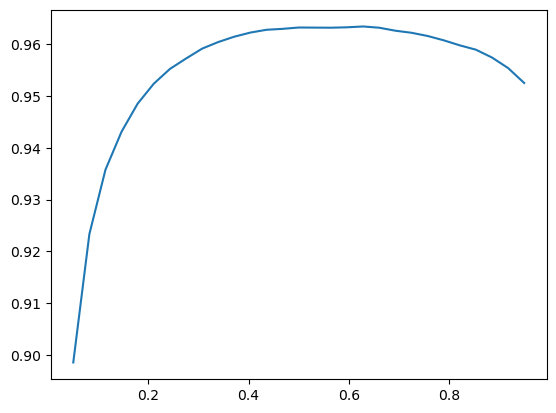

In [31]:
xs = torch.linspace(0.05, 0.95, 29)
accus = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accus)